In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
# from pandas.plotting import register_matplotlib_converters
# register_matplotlib_converters()

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [18]:
df=pd.read_csv('https://raw.githubusercontent.com/sm-joo/sm-joo/master/DEXKOUS.csv', parse_dates=['DATE'], index_col='DATE')
df

,DEXKOUS
DATE,
2015-03-13,1135.7
2015-03-16,1129.62
2015-03-17,1127.69
2015-03-18,1127.09
2015-03-19,1121.21
...,...
2020-03-09,1203.75
2020-03-10,1193.1
2020-03-11,1194.16


In [3]:
df.columns=['KOUS']
df['KOUS'].replace('.', '', inplace=True)
df['KOUS']=pd.to_numeric(df['KOUS'])
df['KOUS'].fillna(method='ffill', inplace=True)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1306 entries, 2015-03-13 to 2020-03-13
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   KOUS    1306 non-null   float64
dtypes: float64(1)
memory usage: 20.4 KB


In [6]:
df=df[(df.index>'2019-01-01')&(df.index<'2020-01-01')]

# ARIMA(p,k,q) => k 결정

In [7]:
adfuller(df.KOUS)

(-1.8342899250680114,
 0.36357542996557135,
 2,
 257,
 {'1%': -3.4560535712549925,
  '10%': -2.5727985212493754,
  '5%': -2.8728527662442334},
 1453.3457437081727)

In [ ]:
adfuller(df.KOUS.diff().dropna()) #!diff():차분!
# k=1로 결정 (1차 차분이 안정적이다.)

(-10.572632524492832,
 7.239046680336767e-19,
 1,
 257,
 {'1%': -3.4560535712549925,
  '10%': -2.5727985212493754,
  '5%': -2.8728527662442334},
 1446.168602565303)

#ARIMA(p,k,q) => p, q 결정

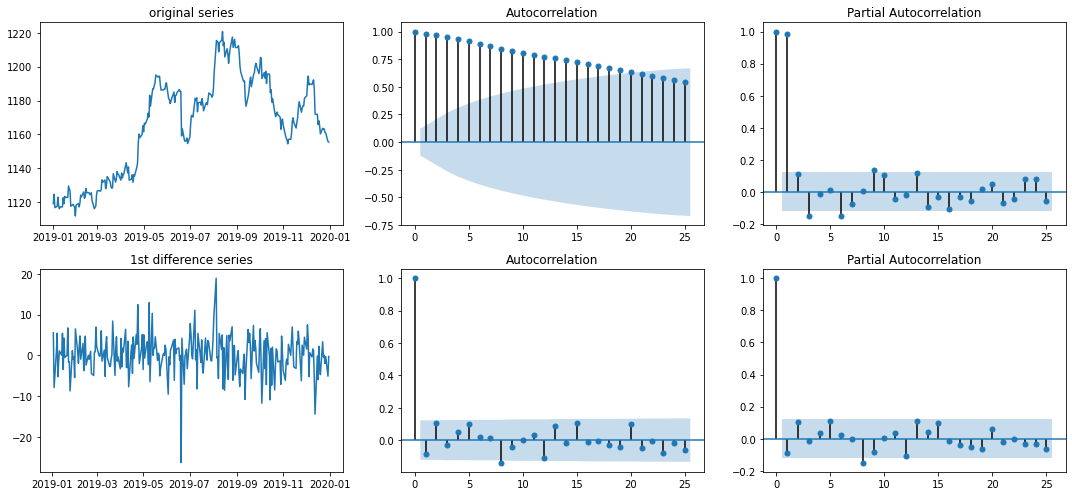

In [ ]:
# 2x3 subplot 
figure, axes= plt.subplots(2, 3, figsize=(15,7))
axes[0,0].plot(df.KOUS)
axes[0,0].set_title('original series')
axes[1,0].plot(df.KOUS.diff())
axes[1,0].set_title('1st difference series')
plot_acf(df.KOUS,axes[0,1])
plot_pacf(df.KOUS,axes[0,2])
plot_acf(df.KOUS.diff().dropna(),axes[1,1])
plot_pacf(df.KOUS.diff().dropna(),axes[1,2])
plt.tight_layout()
plt.show()

In [ ]:
# AR차수 : 3차 or 1차 
# MA차수 : 2차 or  0차 

# ARIMA 예측 모델링


In [9]:
# ARIMA의 차수는 (3,1,2) -> (2,1,2) 3번쨰꺼 의미가 없음
model=ARIMA(df.KOUS, order=(2,1,2), freq='B') #! freq:환율데이터는 비즈니스데이의 B로
model_fit= model.fit(trend='nc')#!'nc' :not constant
print(model_fit.summary())

#! AIC, BIC, HQIC은 작을수록 좋다.

                             ARIMA Model Results                              
Dep. Variable:                 D.KOUS   No. Observations:                  259
Model:                 ARIMA(2, 1, 2)   Log Likelihood                -769.208
Method:                       css-mle   S.D. of innovations              4.715
Date:                Thu, 22 Apr 2021   AIC                           1548.416
Time:                        03:48:40   BIC                           1566.200
Sample:                    01-03-2019   HQIC                          1555.566
                         - 12-31-2019                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
ar.L1.D.KOUS    -1.2447      0.243     -5.123      0.000      -1.721      -0.769
ar.L2.D.KOUS    -0.7340      0.257     -2.851      0.005      -1.239      -0.229
ma.L1.D.KOUS     1.1778      0.245      4.80

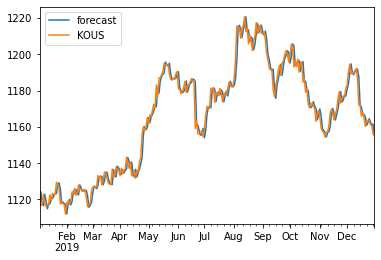

In [11]:
model_fit.plot_predict() #! 이건 전혀 의미 없음 아래과정을 진행하라!

plt.show()

In [12]:
## Training set, Test set을 나누어서 학습과 평가
#! Arima모형계열은 너무 데이터가 많으면 옛날데이터로 지금테이터를 예측하는 게 효과가 떨어짐.
train=df.iloc[0:30]
test=df.iloc[30:35] #! 30번부터 34번 인덱스까지!
test.shape

(5, 1)

In [17]:
model=ARIMA(train, order=(2,1,2), freq='B')
model_fit=model.fit(trend='nc')
fc, se, conf=model_fit.forecast(5, alpha=0.05) #!alpha=0.05:신뢰구간은 95%로 한다는 뜻,1번쨰 환율,  array([3.55652474, 4.20719132, 4.80871712, 5.74495985, 6.93432329]:standard error,array([[1115.74057842, 1129.68189924]:신뢰구간 (왼쪽 하한 오른쪽 상한)

In [14]:
fc_series=pd.Series(fc, index=test.index)
lower_series=pd.Series(conf[:,0], index=test.index)
upper_series=pd.Series(conf[:,1], index=test.index)

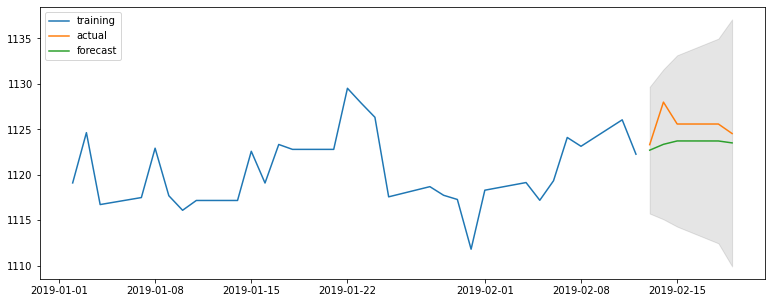

In [ ]:
# plot
plt.figure(figsize=(13,5))
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(test.index, lower_series, upper_series, color='black', alpha=0.1)
plt.legend(loc='upper left')
plt.show()

#결론
- 회색으로 칠해진 범위를 신뢰구간이라고 한다.
- 기존의 패턴에서 예측을 하는 것이기 때문에 이렇게 외부충격으로 튄 경우는 잡아내기 어렵다. 이것이 한계